<center><img src="imagen/Garch-vs-XGBoost.jpg" width="900" height="300"></center>

<a id='abs'></a>
# 1. Resumen
En este cuadernos voy ha utilizar el modelo de Heterocedasticidad Condicional Autoregresiva Generalizada (GARCH) y un modelo XGBoost Machine Learning para predecir la volatilidad de una acción. GARCH es un modelo estadístico ampliamente utilizado para pronosticar la varianza de series temporales financieras y es particularmente útil para modelar la volatilidad de las acciones. Usando datos históricos de la acción, podemos ajustar un modelo GARCH y lo usamos para hacer pronósticos móviles a corto plazo de la volatilidad de la acción. También comparamos el rendimiento de nuestro modelo GARCH con otro modelo de aprendizaje automático más general, XGBoost. Nuestros resultados muestran que el modelo XGBoost es capaz de predecir con precisión la volatilidad mensual continua de las acciones y supera al modelo GARCH en pronósticos fuera de la muestra. Este cuaderno vamos a demuestrar la utilidad de Machine Learning para pronosticar la volatilidad de las acciones y destaca la importancia de considerar la naturaleza variable de la volatilidad en el tiempo en el análisis financiero cuantitativo.


Herramientas: el modelo de heteroscedasticidad condicional autorregresiva generalizada (GARCH) es un modelo estadístico que se utiliza para describir la varianza variable en el tiempo de los datos de series temporales financieras. Se usa comúnmente para modelar la volatilidad de los rendimientos financieros y se puede usar para hacer predicciones sobre la volatilidad futura, en este caso usamos el del módulo "arch".

<br/><br/>

$$ \sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma_{t-1}^2 $$


El modelo Extreme Gradient Boosting (XGBoost) es un potente algoritmo de aprendizaje automático que se utiliza para tareas de clasificación y regresión. Es una implementación de aumento de gradiente que está optimizada para la velocidad y el rendimiento. XGBoost es una opción popular entre los científicos de datos porque proporciona un alto nivel de precisión a la vez que es eficiente y fácil de usar. Funciona creando una serie de árboles de decisión y combinando sus predicciones a través de un modelo de conjunto. El algoritmo puede manejar una variedad de tipos de datos, incluidos valores numéricos, categóricos y faltantes.

### Tabla de contenido

1. [Resumen](#abs)

2. [Importando bibliotecas](#imp)

3. [Lectura de los datos y preprocesamiento](#rea)

4. [EDA: Cálculo de rentabilidad y volatilidad](#eda)

5. [GARCH (4,4) Vs XGBoost](#gar)

6. [Resultados](#res)



<a id='imp'></a>
# 2. Importación librerias

In [1]:
# Procesamiento de Datos
import pandas as pd
import numpy as np
import math
import datetime
import datetime as dt

# Financial Market data
import yfinance as yf

# Statistics
import statsmodels.api as sm
import arch 

from statsmodels.compat import lzip
from statsmodels.tsa.stattools import adfuller

# Modelación
# ==============================================================================
from arch import arch_model
import xgboost as xgb
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

In [2]:
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

# Definir el tamaño del gráfico
# ==============================================================================
from pylab import rcParams
rcParams['figure.figsize'] = (16,5)

# Ocultar warnings
# ==============================================================================
import warnings
warnings.filterwarnings("ignore")

In [3]:
from ipywidgets import HBox, VBox
from tabulate import tabulate
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance, plot_tree

<a id='rea'></a>
# 3. Lectura de datos y preprocesamiento

In [4]:
# Leemos los datos
data = yf.download('^GSPC',start='2020-01-01', 
                      end='2023-04-27',) # S&P500

data.head()

[*********************100%***********************]  1 of 1 completed


Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-01-02  3244.669922  3258.139893  3235.530029  3257.850098  3257.850098   
2020-01-03  3226.360107  3246.149902  3222.340088  3234.850098  3234.850098   
2020-01-06  3217.550049  3246.840088  3214.639893  3246.280029  3246.280029   
2020-01-07  3241.860107  3244.909912  3232.429932  3237.179932  3237.179932   
2020-01-08  3238.590088  3267.070068  3236.669922  3253.050049  3253.050049   

                Volume  
Date                    
2020-01-02  3459930000  
2020-01-03  3484700000  
2020-01-06  3702460000  
2020-01-07  3435910000  
2020-01-08  3726840000

In [5]:
data.tail()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2023-04-20  4130.479980  4148.569824  4114.569824  4129.790039  4129.790039   
2023-04-21  4132.140137  4138.020020  4113.859863  4133.520020  4133.520020   
2023-04-24  4132.069824  4142.410156  4117.770020  4137.040039  4137.040039   
2023-04-25  4126.430176  4126.430176  4071.379883  4071.629883  4071.629883   
2023-04-26  4087.780029  4089.669922  4049.350098  4055.989990  4055.989990   

                Volume  
Date                    
2023-04-20  3772080000  
2023-04-21  3611750000  
2023-04-24  3290940000  
2023-04-25  3978640000  
2023-04-26  3837030000

In [6]:
from skimpy import skim

skim(data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 835    │ │ float64     │ 5     │                                                          │
│ │ Number of columns │ 6      │ │ int32       │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name ┃ NA ┃ NA % ┃ mean     ┃ sd        ┃ p0         ┃ p25        ┃ p75       ┃ p100       ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ Open        │  0 │    0 │     3900 │       530 │       2300 │       3500 │      4300 │       4800 │ ▁▂▄▇█▅ │  │
│ │ High        │  0 │    0 │     3900 │       530 │       2300 │       3500 │      4300 │       4800 │ ▁▂▄▇█▅ │  │
│ │ Low         │  0 │    0 │     3800 │       530 │       2200 │       3500 │      4200 │       4800 │ ▁▂▄▆█▅ │  │
│ │ Close       │  0 │    0 │     3900 │       530 │       2200 │       3500 │      4300 │       4800 │ ▁▂▄▆█▅ │  │
│ │ Adj Close   │  0 │    0 │     3900 │       530 │       2200 │       3500 │      4300 │       4800 │ ▁▂▄▆█▅ │  │
│ │ Volume      │  0 │    0 │ 13000000 │ 780000000 │ -210000000 │ -470000000 │ 500000000 │ 2100000000 │ ▁▂█▆▃▁ │  │
│ │             │    │      │          │           │          0 │            │           │            │        │  │
│ └─────────────┴────┴──────┴──────────┴───────────┴────────────┴────────────┴───────────┴────────────┴────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [6]:
data.set_index("Date", inplace=True)

## Serie sin tendencias</h1>
Para modelar, necesitaremos eliminar la tendencia de la serie. La forma más sencilla de hacerlo es calcular el cambio porcentual en los precios de cierre diarios.</p>

Deberá convertir el precio diario de las acciones en un rendimiento diario de las acciones. Esto se puede calcular como $𝑅=\frac{P_t-P_{t-1}}{P_{t-1}} \times 100 \%$, donde $P_t$ es el precio en el momento $𝑡$ y $P_{t-1}$ es el precio anterior (1 día antes). Esto se puede hacer fácilmente en pandas usando la función `DataFrame.pct_change()`. La función `pct_change()` tiene un parámetro de períodos cuyo valor predeterminado es 1. Si desea calcular un retorno de 30 días, debe cambiar el valor a 30:

In [7]:
# Calcular el cambio porcentual por día.
retorno = 100 * data[["Close"]].pct_change().dropna() 
retorno.head()

Close
Date                
2020-01-03 -0.705987
2020-01-06  0.353337
2020-01-07 -0.280324
2020-01-08  0.490245
2020-01-09  0.665526

<a id='eda'></a>
# 4.EDA: Visualización de rendimientos y volatilidad

In [8]:
# Promedio de los retornos
round(retorno.mean(),4)

Close    0.0384
dtype: float64

La media del % de rendimiento diario es 0.1125%, pero no utilizaremos esa información, ya que estudiaremos la volatilidad.

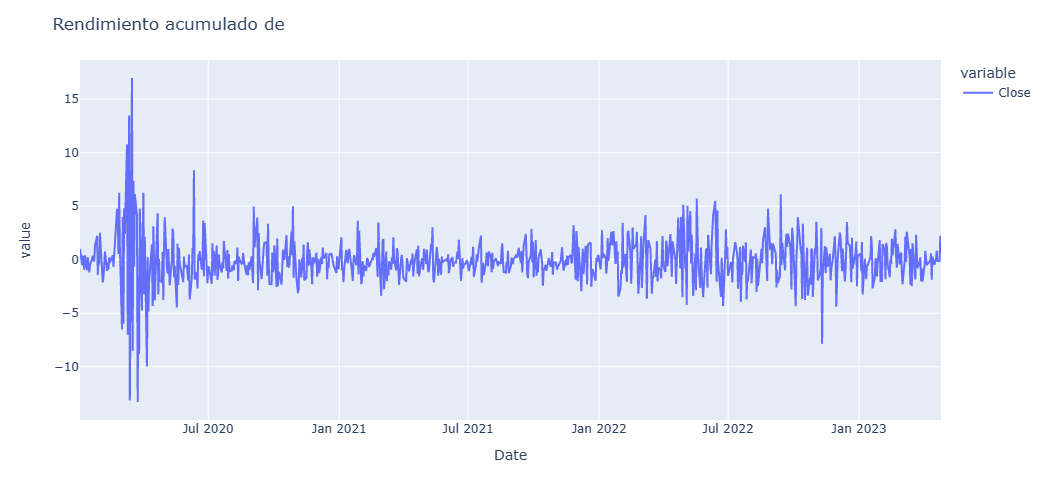

In [9]:
# Uso de los precios de cierre sin procesar para trazar la evolución de la acción
close_prices = retorno
# Al dividir cada precio de cierre por el primer precio en nuestro conjunto de datos, calculamos el rendimiento acumuladopara cada día
cum_rets = close_prices / close_prices.iloc[0,:]

# Usando el módulo plotly.express podemos trazar nuestros cum_rets recién creados
fig = px.line(cum_rets.iloc[:,:], width=800, height=500)
# Agregamos titulo
fig.update_layout(title_text="Rendimiento acumulado de ")

fig.show()

## 4.1 Medición de la volatilidad

In [10]:
# La volatilidad diaria es el std de los retornos
daily_volatility = round(retorno.values.std(),4)
daily_volatility

1.5543

La volatilidad mensual es el resultado de multiplicar la volatilidad diaria * la raíz cuadrada de 21, esto se debe a que hay 21 días hábiles en un mes


In [11]:
monthly_volatility = math.sqrt(21) * daily_volatility

La volatilidad anual es el resultado de multiplicar la volatilidad diaria * raíz cuadrada de 252, esto se debe a que en un año hay 252 días hábiles.

In [12]:
annual_volatility = math.sqrt(252) * daily_volatility
annual_volatility

24.67374757672616

In [13]:

#Using tabulate package we can print a nice table
print(tabulate([['Acción',daily_volatility,monthly_volatility,annual_volatility]],
               headers = ['Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %'],
               tablefmt = 'fancy_grid',stralign='center',numalign='center',floatfmt=".2f"))

╒════════╤══════════════════════╤════════════════════════╤═══════════════════════╕
│        │  Daily Volatility %  │  Monthly Volatility %  │  Annual Volatility %  │
╞════════╪══════════════════════╪════════════════════════╪═══════════════════════╡
│ Acción │         1.55         │          7.12          │         24.67         │
╘════════╧══════════════════════╧════════════════════════╧═══════════════════════╛


Gráficando los retornos diarios

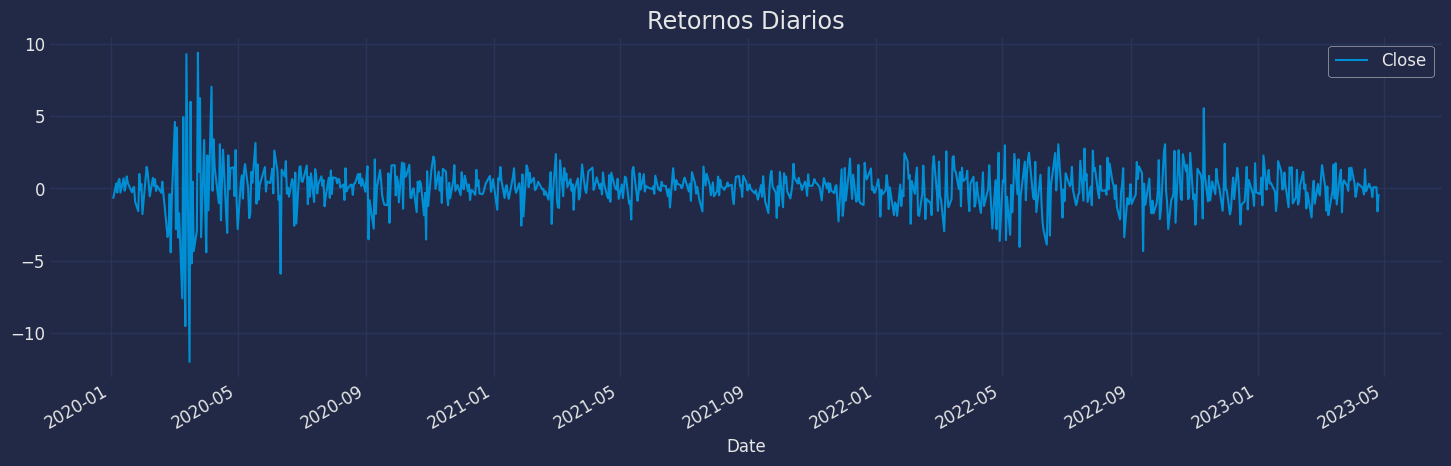

In [14]:
#We can plot the daily retuns of repsol using a line graph using .plot from pandas
retorno.plot(figsize =(16,5), title = 'Retornos Diarios');

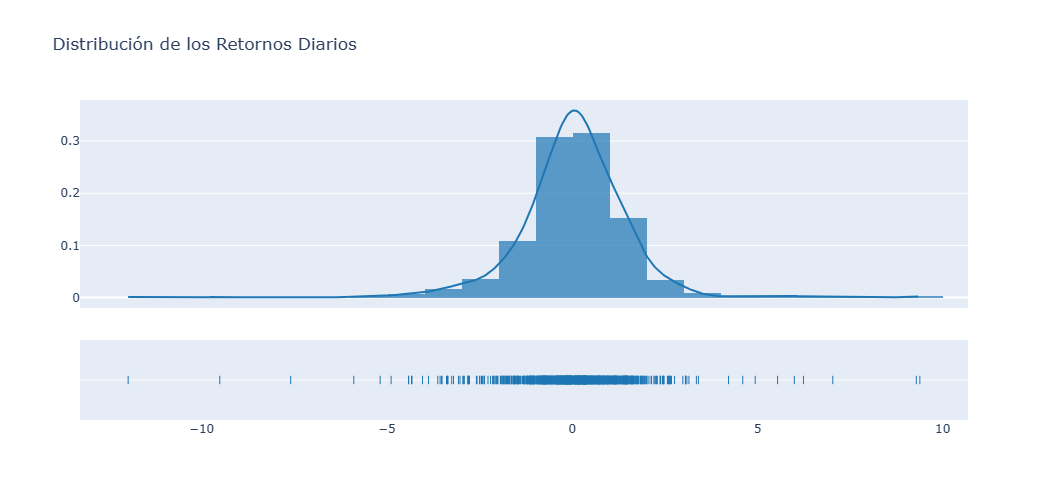

In [111]:
# Creamos un gráfico de distribución usando plotly.figure_factory, remodelamos los datos para tenerlos en un vector
return_dist_plot  = ff.create_distplot([retorno.values.reshape(-1)], group_labels = [' '])
#We specify the plot layout
return_dist_plot.update_layout(showlegend=False, title_text='Distribución de los Retornos Diarios', width=1000, height=500)
#Printing the plot
return_dist_plot.show()

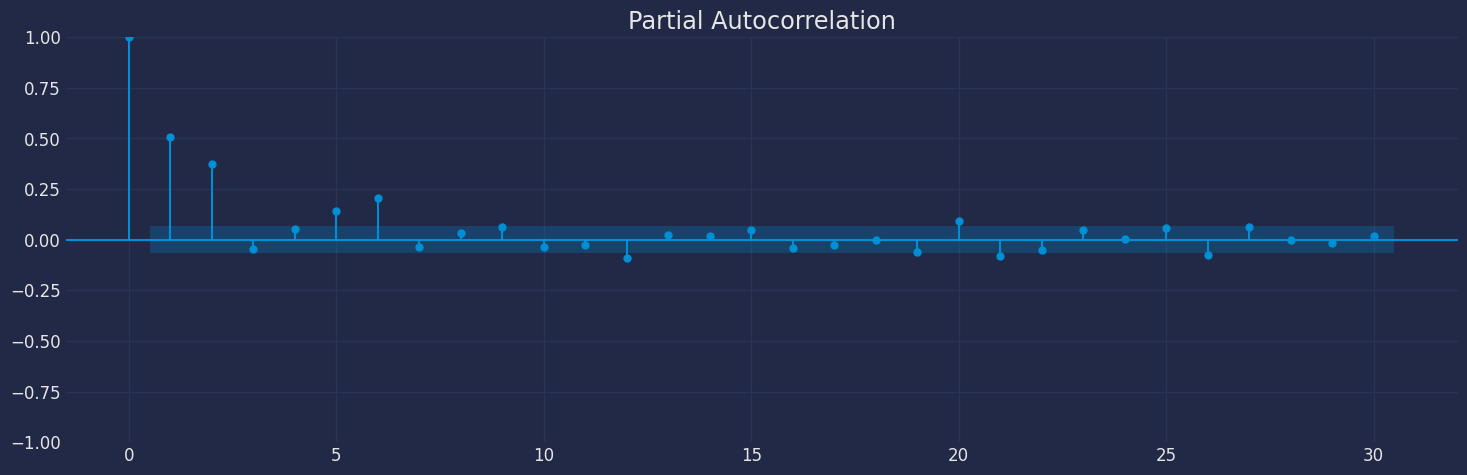

In [15]:
# Gráficando la autocorrelación parcial 
plot_pacf(retorno**2,method="yw")

plt.show()

Este gráfico muestra la autocorrelación de los rendimientos al cuadrado, este resultado positivo nos permitirá predecir la volatilidad utilizando un modelo GARCH, o agregando la volatilidad anterior como una característica de nuestro modelo XGBoost.

<a id='gar'></a>
# 5. GARCH (4,4) vs XGBoost

## 5.1 GARCH

In [16]:
#Define a GARCH model (4,4) that uses a ged distribution
model = arch_model(retorno,dist="ged", vol = 'GARCH', p=4, q=4)
#Fit the model
model_fit = model.fit(disp='off')
#Summary of the model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                            
==========================================================================================
Dep. Variable:                              Close   R-squared:                       0.000
Mean Model:                         Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                  GARCH   Log-Likelihood:               -1323.84
Distribution:      Generalized Error Distribution   AIC:                           2669.68
Method:                        Maximum Likelihood   BIC:                           2721.67
                                                    No. Observations:                  834
Date:                            Thu, Apr 27 2023   Df Residuals:                      833
Time:                                    12:30:01   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0980  3.313e-02      2.957  3.107e-03 [3.303e-02,  0.163]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1686      0.248      0.680      0.497    [ -0.318,  0.655]
alpha[1]       0.1362  7.288e-02      1.869  6.162e-02 [-6.628e-03,  0.279]
alpha[2]       0.2214      0.281      0.789      0.430    [ -0.329,  0.771]
alpha[3]       0.1058      0.360      0.294      0.769    [ -0.600,  0.812]
alpha[4]       0.0499      0.145      0.345      0.730    [ -0.234,  0.333]
beta[1]    5.5947e-16      1.906  2.935e-16      1.000    [ -3.736,  3.736]
beta[2]        0.0000      0.659      0.000      1.000    [ -1.292,  1.292]
beta[3]        0.2695      0.152      1.778  7.537e-02 [-2.755e-02,  0.567]
beta[4]        0.1571      0.617      0.255      0.799    [ -1.052,  1.366]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.4314      0.103     13.957  2.838e-44 [  1.230,  1.632]
========================================================================

Covariance estimator: robust
"""

In [18]:
# Definir la serie completa como el modelo previamente definido
full_serie_garch = arch_model(retorno,dist="ged", vol = 'GARCH', p=4, q=4)
# Ajuste del modelo para la serie completa
model_fit_full_serie = full_serie_garch.fit(disp='off')


In [19]:
# Conspiraremos contra la volatilidad rodante
rolling_vol = abs(retorno.rolling(window=22, min_periods=22).std().dropna())
rolling_vol

Close
Date                
2020-02-04  0.792352
2020-02-05  0.804343
2020-02-06  0.804095
2020-02-07  0.812431
2020-02-10  0.819184
...              ...
2023-04-20  0.740009
2023-04-21  0.698554
2023-04-24  0.572969
2023-04-25  0.690001
2023-04-26  0.691975

[813 rows x 1 columns]

In [20]:
# Concatenando los valores verdaderos y los valores entrenados en nuestro modelo
garch_and_rolling_std = pd.concat([pd.DataFrame(model_fit_full_serie.conditional_volatility),
                                   rolling_vol.dropna()], axis=1).dropna()

garch_and_rolling_std

cond_vol     Close
Date                          
2020-02-04  1.201958  0.792352
2020-02-05  1.117568  0.804343
2020-02-06  1.184400  0.804095
2020-02-07  1.101074  0.812431
2020-02-10  1.004578  0.819184
...              ...       ...
2023-04-20  0.712456  0.740009
2023-04-21  0.725374  0.698554
2023-04-24  0.719416  0.572969
2023-04-25  0.665153  0.690001
2023-04-26  0.893411  0.691975

[813 rows x 2 columns]

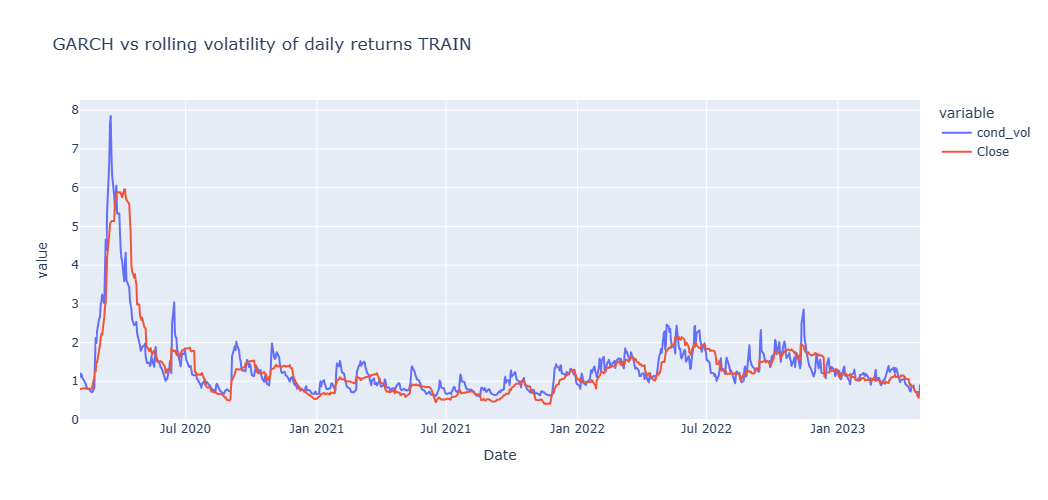

In [21]:
#Plotting it
garch_and_rolling_std_plot = px.line(garch_and_rolling_std, 
                                     title = 'GARCH vs rolling volatility of daily returns TRAIN',
                                     width=1000, height=500)
#Printing the plot
garch_and_rolling_std_plot.show()

Usando un rango numérico de 90 para llenar una lista de valores pronosticados, para cada día estamos ajustando un nuevo modelo con los mismos parámetros, pero agregando el último día.


In [24]:
test_size = 90 # Los últimos 90 días 
rolling_predictions = []

for i in range(test_size):
    train = retorno[:-(test_size-i)]
    model = arch_model(train,dist="ged", vol = 'GARCH', p=4, q=4)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, reindex = False)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [23]:
rolling_predictions

[1.0695629202484978,
 1.4597481675358441,
 1.6152090573041444,
 1.4138164587681572,
 1.2895010086624237,
 1.2707503669924465,
 1.3989726182327402,
 1.2895647726856743,
 1.1425978014495541,
 1.1837303018252368,
 1.321714400167245,
 1.2507402202102418,
 1.0899267891825923,
 1.0606755405998183,
 1.1018318889974785,
 1.3941867843772997,
 1.361197942088203,
 1.1395249380792303,
 1.2033164690317681,
 1.1270566976065015,
 0.9982834135883225,
 0.9229474443727863,
 1.1005859088570662,
 1.1576841603828154,
 1.2323708797070523,
 1.3167648578664815,
 1.1458421657191198,
 1.0504057824499564,
 1.038726658448284,
 0.999316918923955,
 1.0421005747661434,
 1.185231562032836,
 1.1473970548021157,
 1.1858143289613292,
 1.2228026839588784,
 1.1526533747716357,
 1.1500098247143238,
 1.199345327871829,
 1.1789269720822426,
 1.0761379954780543,
 1.0540911154129056,
 1.020344004732963,
 0.8964937410975257,
 1.036467960196176,
 1.0457367047745547,
 1.2288820212227927,
 1.2979206819305817,
 1.057205471664087,
 

In [25]:
#Transforming it to a serie 
rolling_pred = pd.DataFrame(rolling_predictions,index= retorno.index[-test_size:])
rolling_pred=rolling_pred.rename(columns={0: 'pred'})                   

rolling_pred

pred
Date                
2022-12-15  1.069563
2022-12-16  1.459748
2022-12-19  1.615209
2022-12-20  1.413816
2022-12-21  1.289501
...              ...
2023-04-20  0.703213
2023-04-21  0.723646
2023-04-24  0.710759
2023-04-25  0.649667
2023-04-26  0.898818

[90 rows x 1 columns]

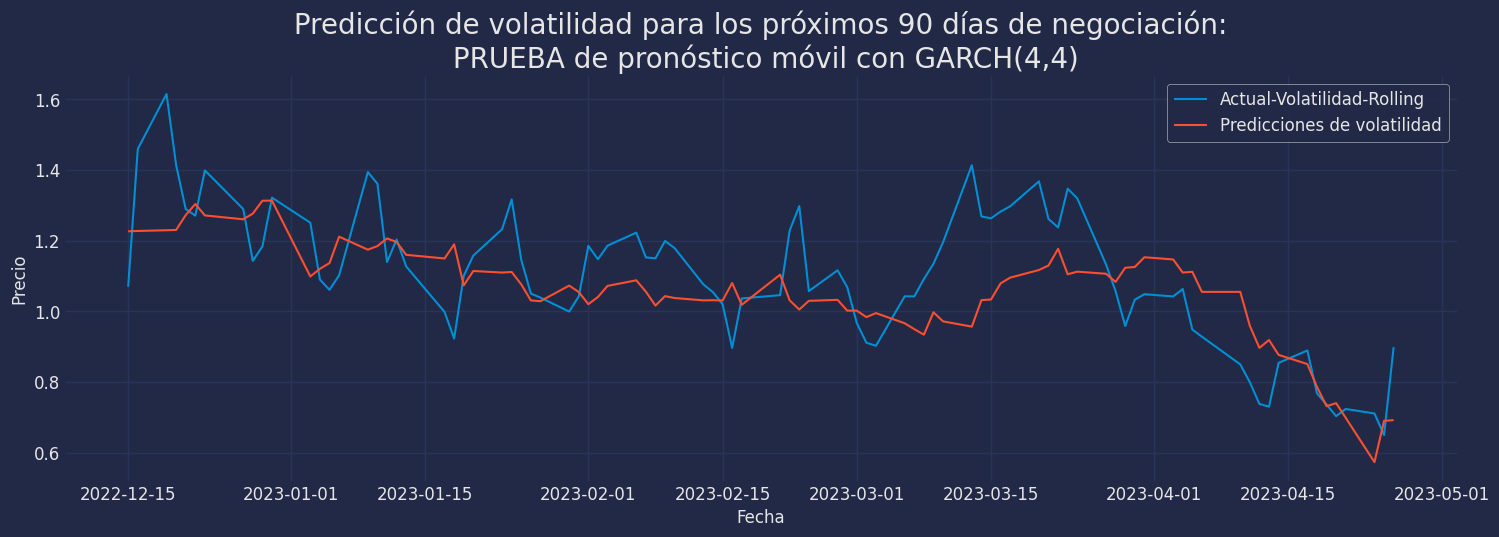

In [26]:
# Graficar los datos reales y las predicciones de volatilidad

plt.plot(rolling_pred, label="Actual-Volatilidad-Rolling")
plt.plot((rolling_vol)[-test_size:], label="Predicciones de volatilidad")
#Plot of the data
plt.title(' Predicción de volatilidad para los próximos 90 días de negociación: \n PRUEBA de pronóstico móvil con GARCH(4,4)', 
          fontsize=20)
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend()
plt.show()

## 5.2 XGBoost

In [27]:
df = yf.download('^GSPC',start='2020-01-01', 
                      end='2023-04-27',)

# Seleccionamos las columnas fecha y Close
df_ml = df[["Close"]] 
df_ml.head()

[*********************100%***********************]  1 of 1 completed


Close
Date                   
2020-01-02  3257.850098
2020-01-03  3234.850098
2020-01-06  3246.280029
2020-01-07  3237.179932
2020-01-08  3253.050049

In [28]:
# 
df_ml["retorno"] = 100 * df_ml["Close"].pct_change().dropna()
df_ml=df_ml.dropna()
df_ml.head()

Close   retorno
Date                             
2020-01-03  3234.850098 -0.705987
2020-01-06  3246.280029  0.353337
2020-01-07  3237.179932 -0.280324
2020-01-08  3253.050049  0.490245
2020-01-09  3274.699951  0.665526

In [29]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 834 entries, 2020-01-03 to 2023-04-26
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Close    834 non-null    float64
 1   retorno  834 non-null    float64
dtypes: float64(2)
memory usage: 19.5 KB


In [30]:
df_ml.describe()

Close     retorno
count   834.000000  834.000000
mean   3878.281909    0.038428
std     527.245607    1.555195
min    2237.399902  -11.984055
25%    3508.367493   -0.666537
50%    3953.285034    0.085340
75%    4270.457397    0.815948
max    4796.560059    9.382774

In [31]:
df_ml["win_22"]=abs(df_ml["retorno"].rolling(window=22, min_periods=22).std().dropna())
df_ml.head(23)

Close   retorno    win_22
Date                                       
2020-01-03  3234.850098 -0.705987       NaN
2020-01-06  3246.280029  0.353337       NaN
2020-01-07  3237.179932 -0.280324       NaN
2020-01-08  3253.050049  0.490245       NaN
2020-01-09  3274.699951  0.665526       NaN
2020-01-10  3265.350098 -0.285518       NaN
2020-01-13  3288.129883  0.697622       NaN
2020-01-14  3283.149902 -0.151453       NaN
2020-01-15  3289.290039  0.187020       NaN
2020-01-16  3316.810059  0.836655       NaN
2020-01-17  3329.620117  0.386216       NaN
2020-01-21  3320.790039 -0.265198       NaN
2020-01-22  3321.750000  0.028908       NaN
2020-01-23  3325.540039  0.114098       NaN
2020-01-24  3295.469971 -0.904216       NaN
2020-01-27  3243.629883 -1.573071       NaN
2020-01-28  3276.239990  1.005358       NaN
2020-01-29  3273.399902 -0.086687       NaN
2020-01-30  3283.659912  0.313436       NaN
2020-01-31  3225.520020 -1.770582       NaN
2020-02-03  3248.919922  0.725461       NaN
2020-02-04  3297.590088  1.498041  0.792352
2020-02-05  3334.689941  1.125060  0.804343

In [32]:
df_ml.reset_index(inplace=True)

In [33]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834 entries, 0 to 833
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     834 non-null    datetime64[ns]
 1   Close    834 non-null    float64       
 2   retorno  834 non-null    float64       
 3   win_22   813 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 26.2 KB


In [138]:
#Convert the date column to datetime format
df_ml["Date"] = pd.to_datetime(df_ml["Date"])

In [34]:
#Rename the dataframe
serie_for_xgboost = df_ml
#Set the test size
test_size = 90
#Split train and test
train_ml = serie_for_xgboost[:-(test_size)].dropna()
test_ml = serie_for_xgboost[-(test_size):].dropna()

In [35]:
train_ml.head()

Date        Close   retorno    win_22
21 2020-02-04  3297.590088  1.498041  0.792352
22 2020-02-05  3334.689941  1.125060  0.804343
23 2020-02-06  3345.780029  0.332567  0.804095
24 2020-02-07  3327.709961 -0.540085  0.812431
25 2020-02-10  3352.090088  0.732640  0.819184

In [36]:
train_ml.shape, test_ml.shape

((723, 4), (90, 4))

In [37]:
#UDF for extracting features from date
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [38]:
#Creating the features for the train and test sets
X_train, y_train = create_features(train_ml, label="win_22")
X_test, y_test = create_features(test_ml, label="win_22")

In [39]:
X_train.head()

dayofweek  quarter  month  year  dayofyear  dayofmonth
21          1        1      2  2020         35           4
22          2        1      2  2020         36           5
23          3        1      2  2020         37           6
24          4        1      2  2020         38           7
25          0        1      2  2020         41          10

In [40]:
#Creating an aditional feature that uses the 4 previous days of rolling volatility, incorporating the autoregressive component to our ML model
X_train['prev1']=train_ml['win_22'].shift(1)
X_test['prev1']=test_ml['win_22'].shift(1)
X_train['prev2'] =train_ml['win_22'].shift(2)
X_test['prev2']=test_ml['win_22'].shift(2)
X_train['prev3'] =train_ml['win_22'].shift(3)
X_test['prev3']=test_ml['win_22'].shift(3)
X_train['prev4'] =train_ml['win_22'].shift(4)
X_test['prev4']=test_ml['win_22'].shift(4)

In [41]:
X_train

dayofweek  quarter  month  year  dayofyear  dayofmonth     prev1  \
21           1        1      2  2020         35           4       NaN   
22           2        1      2  2020         36           5  0.792352   
23           3        1      2  2020         37           6  0.804343   
24           4        1      2  2020         38           7  0.804095   
25           0        1      2  2020         41          10  0.812431   
..         ...      ...    ...   ...        ...         ...       ...   
739          3        4     12  2022        342           8  1.668062   
740          4        4     12  2022        343           9  1.664142   
741          0        4     12  2022        346          12  1.673551   
742          1        4     12  2022        347          13  1.618556   
743          2        4     12  2022        348          14  1.125930   

        prev2     prev3     prev4  
21        NaN       NaN       NaN  
22        NaN       NaN       NaN  
23   0.792352       NaN       NaN  
24   0.804343  0.792352       NaN  
25   0.804095  0.804343  0.792352  
..        ...       ...       ...  
739  1.683311  1.666678  1.715166  
740  1.668062  1.683311  1.666678  
741  1.664142  1.668062  1.683311  
742  1.673551  1.664142  1.668062  
743  1.618556  1.673551  1.664142  

[723 rows x 10 columns]

## Implementación del Modelo XGBoost

In [42]:
# Definimos el modelo
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,)

# Entrenamos al modelo
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

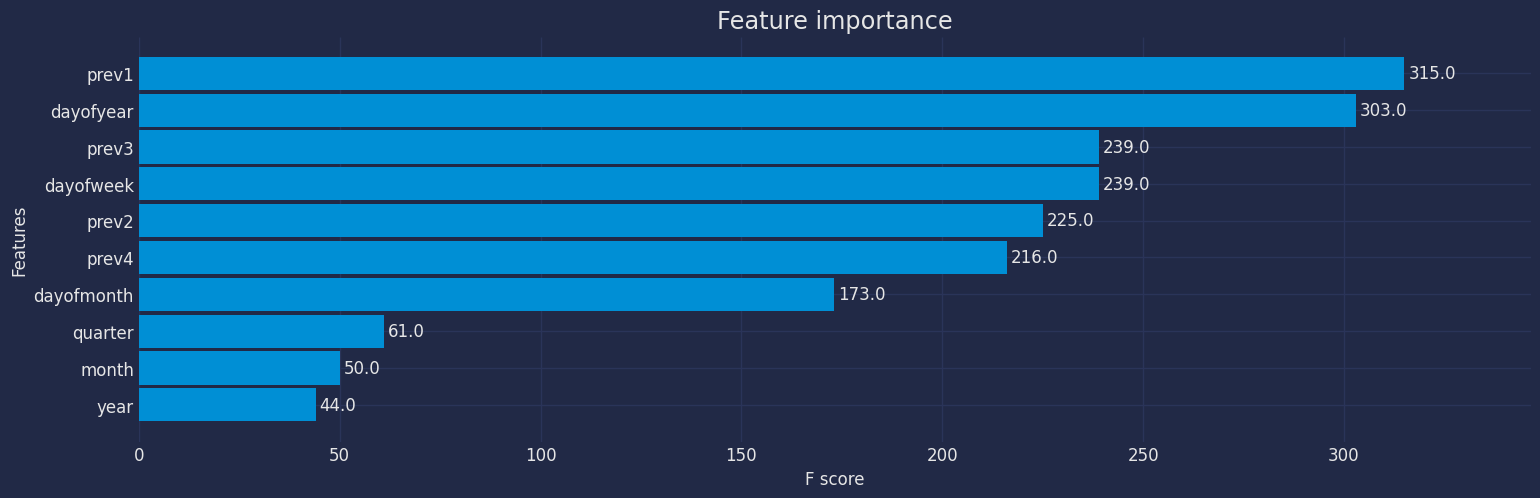

In [43]:
# Visualizamos las variables de importancia (feature importance)
_ = plot_importance(reg, height=0.9)

In [44]:
# Realiamod las predicciones para los train y test 
train_ml["Predictions"] = reg.predict(X_train)
test_ml['Prediction'] = reg.predict(X_test)

In [45]:
# Creamos un dataframe con los real y predicted vol
XGBoost_and_rolling = pd.concat([pd.DataFrame(list(train_ml["Predictions"]),list(train_ml["win_22"]))],
                                axis=1).dropna().reset_index()
# Renaming columns
XGBoost_and_rolling.rename(columns={"index":"Real_Volatility",0:"Predicted Volatility"}, inplace=True)
XGBoost_and_rolling.head(3)

Real_Volatility  Predicted Volatility
0         0.792352              0.785748
1         0.804343              0.787866
2         0.804095              0.794688

In [46]:
XGBoost_and_rolling.set_index(train_ml["Date"], inplace=True)

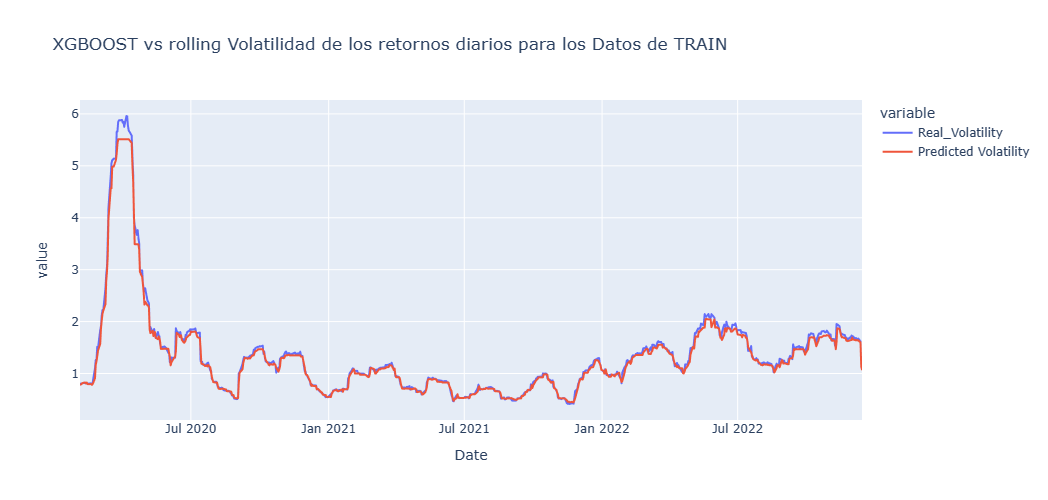

In [47]:
XGBoost_and_rolling = px.line(XGBoost_and_rolling, 
                              title = 'XGBOOST vs rolling Volatilidad de los retornos diarios para los Datos de TRAIN', 
                              width=1000, height=500)
XGBoost_and_rolling.show()

In [48]:
test_ml.set_index("Date", inplace=True)

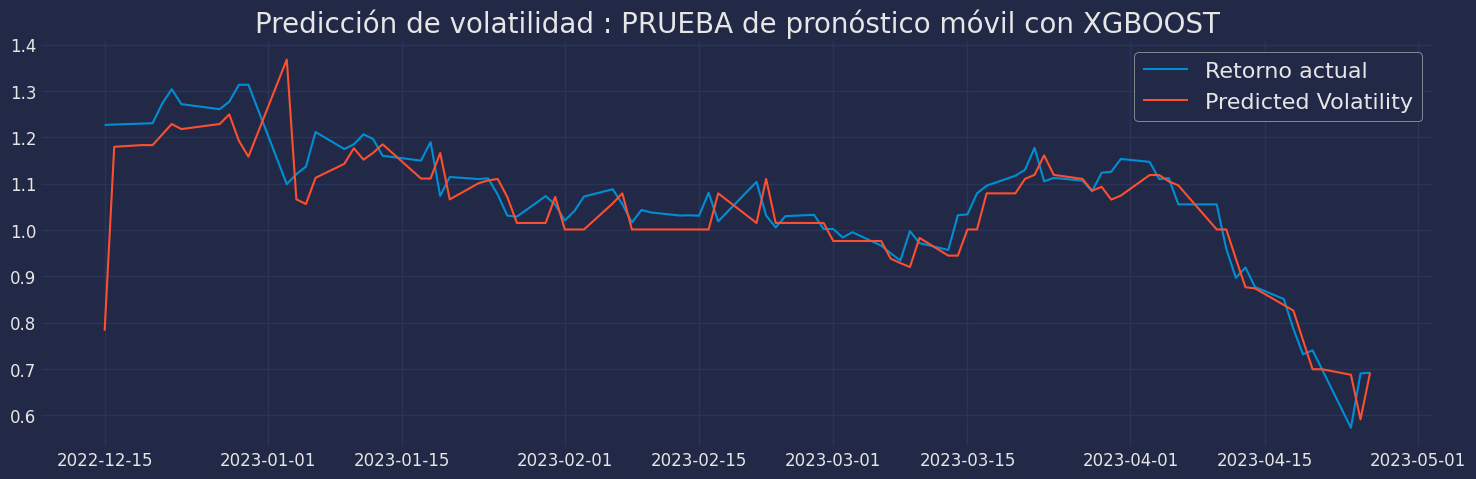

In [49]:
#Plotting the predictions for the test data

true, = plt.plot(test_ml["win_22"])
preds, = plt.plot(test_ml['Prediction'])
plt.title('Predicción de volatilidad : PRUEBA de pronóstico móvil con XGBOOST', fontsize=20)
plt.legend(['Retorno actual', 'Predicted Volatility'], fontsize=16);

<a id='res'></a>
# 6. Results

Metricas: 
<br/><br/>

Root Mean Square Error, RMSE: Raíz cuadrada de la media de la diferencia entre
los puntos de datos reales y el valor de predicción al cuadrado. penaliza
diferencias mayores o extremas más.


El RMSE del modelo es:
$$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

donde n es el número de muestras, $y_i$ es el valor real de la i-ésima muestra y $\hat{y}_i$ es el valor predicho de la i-ésima muestra.

<br/><br/>
Error Medio Absoluto Porcentual, MAPE: Permite medir
errores relativos a la magnitud del valor real.


El MAPE del modelo es:
$$\text{MAPE} = \frac{100}{n} \sum_{i=1}^{n} \frac{|A_i - F_i|}{|A_i|}$$

donde $A_i$ es el valor real de la i-ésima muestra, $F_i$ es el valor pronosticado de la i-ésima muestra y $n$ es el número total de muestras.


In [50]:
RMSE_Serie = mean_squared_error(garch_and_rolling_std["Close"],garch_and_rolling_std["cond_vol"],squared=False)
MAPE_Serie = mean_absolute_percentage_error(garch_and_rolling_std["Close"], garch_and_rolling_std["cond_vol"])
print(f"El RMSE de nuestro modelo GARCH en los datos de la serie completa es {round(RMSE_Serie,4)}")
print(f"El MAPE de nuestro modelo GARCH en los datos de la serie completa es {round(MAPE_Serie*100,2)}%")

El RMSE de nuestro modelo GARCH en los datos de la serie completa es 0.4017
El MAPE de nuestro modelo GARCH en los datos de la serie completa es 19.22%


In [51]:
true_vol = rolling_vol[-test_size:]
pred_vol = rolling_predictions
RMSE = mean_squared_error(true_vol, pred_vol,squared=False)
MAPE = mean_absolute_percentage_error(true_vol, pred_vol)
print(f"El RMSE de nuestro modelo GARCH en los datos predichos es {round(RMSE,4)}")
print(f"El MAPE de nuestro modelo GARCH en los datos predichos es {round(MAPE*100,2)}%")

El RMSE de nuestro modelo GARCH en los datos predichos es 0.1466
El MAPE de nuestro modelo GARCH en los datos predichos es 11.2%


In [52]:
RMSE_Serie_XG = mean_squared_error(train_ml["win_22"],train_ml["Predictions"],squared=False)
MAPE_Serie_XG = mean_absolute_percentage_error(train_ml["win_22"], train_ml["Predictions"])
print(f"El RMSE de nuestro modelo XGBOOST en los datos de la serie completa es {round(RMSE_Serie_XG,4)}")
print(f"El MAPE de nuestro modelo XGBOOST en los datos de la serie completa es {round(MAPE_Serie_XG*100,2)}%")

El RMSE de nuestro modelo XGBOOST en los datos de la serie completa es 0.0834
El MAPE de nuestro modelo XGBOOST en los datos de la serie completa es 3.5%


In [53]:
true_vol = test_ml['Prediction']
pred_vol = test_ml["win_22"]
RMSE_XG = mean_squared_error(true_vol, pred_vol,squared=False)
MAPE_XG = mean_absolute_percentage_error(true_vol, pred_vol)
print(f"El RMSE de nuestro modelo XGBOOST en los datos previstos es {round(RMSE_XG,4)}")
print(f"El MAPE de nuestro modelo XGBOOST en los datos predichos es {round(MAPE_XG*100,2)}%")

El RMSE de nuestro modelo XGBOOST en los datos previstos es 0.0745
El MAPE de nuestro modelo XGBOOST en los datos predichos es 4.76%


In [54]:
print(tabulate([['MAPE',round(MAPE_Serie*100,2),round(MAPE_Serie_XG*100,2),round(MAPE*100,2),round(MAPE_XG*100,2)]],headers = ['GARCH TRAIN %', 'XGBOOST TRAIN %', 'GARCH PREDICTIONS %','XGBOOST PREDICTIONS %'],tablefmt = 'fancy_grid',stralign='center',numalign='center',floatfmt=".2f"))

╒══════╤═════════════════╤═══════════════════╤═══════════════════════╤═════════════════════════╕
│      │  GARCH TRAIN %  │  XGBOOST TRAIN %  │  GARCH PREDICTIONS %  │  XGBOOST PREDICTIONS %  │
╞══════╪═════════════════╪═══════════════════╪═══════════════════════╪═════════════════════════╡
│ MAPE │      19.22      │       3.50        │         11.20         │          4.76           │
╘══════╧═════════════════╧═══════════════════╧═══════════════════════╧═════════════════════════╛


In [55]:
print(tabulate([['RMSE',round(RMSE_Serie*100,2),round(RMSE_Serie_XG*100,2),round(RMSE*100,2),round(RMSE_XG*100,2)]],headers = ['GARCH TRAIN %', 'XGBOOST TRAIN %', 'GARCH PREDICTIONS %','XGBOOST PREDICTIONS %'],tablefmt = 'fancy_grid',stralign='center',numalign='center',floatfmt=".2f"))

╒══════╤═════════════════╤═══════════════════╤═══════════════════════╤═════════════════════════╕
│      │  GARCH TRAIN %  │  XGBOOST TRAIN %  │  GARCH PREDICTIONS %  │  XGBOOST PREDICTIONS %  │
╞══════╪═════════════════╪═══════════════════╪═══════════════════════╪═════════════════════════╡
│ RMSE │      40.17      │       8.34        │         14.66         │          7.45           │
╘══════╧═════════════════╧═══════════════════╧═══════════════════════╧═════════════════════════╛


Nuestro estudio ha demostrado que el modelo GARCH puede predecir de forma eficaz la volatilidad móvil mensual de las acciones. Sin embargo, otros enfoques modernos como XGBoost pueden mejorar esto, como se ve en nuestros resultados donde el MAPE se redujo a la mitad a 4.43 %. Este proyecto muestra la utilidad de Machine Learning y GARCH para pronosticar la volatilidad de las acciones y subraya la importancia de tener en cuenta la naturaleza cambiante de la volatilidad en el análisis financiero. Si bien estos hallazgos son prometedores, se necesita más investigación para probar estas teorías en una gama más amplia de acciones, mercados y modelos para llegar a conclusiones más generales.
